this notebook, i've attempted to take in all the 6 data vectors (ax,ay,az,gx,gy and gz) and fitted it into a 1D CNN and the output of that is fit into a simple DNN.

In [2]:
# Imports

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models, callbacks, utils

# For reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries loaded. TensorFlow version:", tf.__version__)

Libraries loaded. TensorFlow version: 2.19.0


In [3]:
# User-configurable variables

FILE_MAP = {
    'motor_off': 'motor_off.xlsx',
    'motor_on': 'motor_on.xlsx',
    'motor_on_nofan': 'motor_on_nofan.xlsx',
    'motor_on_badfan': 'motor_on_badfan.xlsx'
}

SENSOR_COLUMNS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
LABEL_COLUMN = 'class_label'
TIME_COLUMN = 'timestamp'

# Windowing params
WINDOW_SIZE = 512
STEP = 256

# Train/test split
TEST_SIZE = 0.3
VAL_SIZE = 0.2

BATCH_SIZE = 32
EPOCHS = 100

In [4]:
# Load datasets

frames = []

for key, fname in FILE_MAP.items():
    df = pd.read_excel(fname)
    df.columns = [c.strip().lower() for c in df.columns]
    frames.append(df)

# Concatenate into a single DataFrame
df_all = pd.concat(frames, axis=0, ignore_index=True)
print(f"Loaded {len(frames)} files. Combined shape: {df_all.shape}")

# Quick type conversions
for col in SENSOR_COLUMNS:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# If timestamp present, ensure parsed
if TIME_COLUMN in df_all.columns:
    try:
        df_all[TIME_COLUMN] = pd.to_datetime(df_all[TIME_COLUMN])
    except Exception:
        # leave as-is if parsing fails
        pass

Loaded 4 files. Combined shape: (72000, 8)


## EDA

In [6]:
# Value count for columns
print('\n### Value counts of labels:')
print(df_all[LABEL_COLUMN].value_counts())

# Summary statistics for sensor columns
print('\nSummary statistics (sensors):')
print(df_all[SENSOR_COLUMNS].describe().T)


### Value counts of labels:
class_label
0    18000
1    18000
2    18000
3    18000
Name: count, dtype: int64

Summary statistics (sensors):
      count      mean        std        min       25%       50%       75%  \
ax  72000.0  0.019746   0.122918  -0.371612 -0.014152  0.020740  0.049532   
ay  72000.0 -0.372166   0.485372  -1.469124 -0.934764 -0.137128 -0.038308   
az  72000.0  0.634136   0.613359  -0.972096  0.199348  0.890844  1.023336   
gx  72000.0 -0.704403  10.687206 -43.207500 -3.325000 -0.665000  1.260000   
gy  72000.0 -0.082164   6.769135 -29.242500 -0.437500 -0.087500  0.332500   
gz  72000.0 -0.258987   2.359902  -8.960000 -0.787500 -0.315000  0.245000   

          max  
ax   0.428220  
ay   0.535092  
az   2.081564  
gx  41.877500  
gy  32.637500  
gz  10.010000  


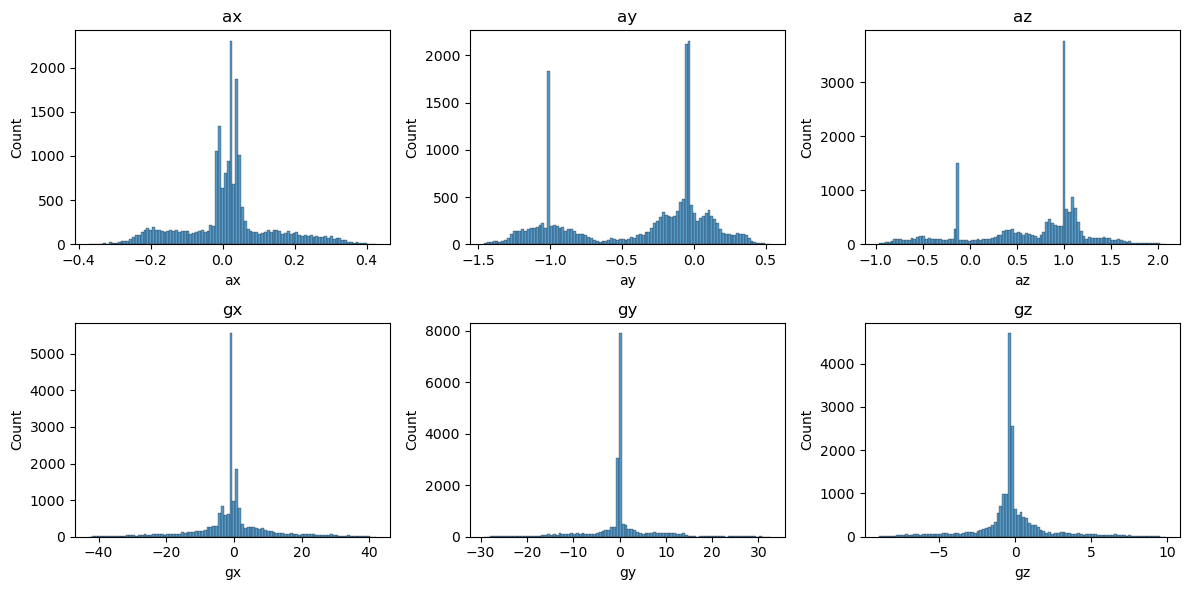

In [7]:
# Plot distributions of each sensor channel (random subset if too many points)
PLOT_N = 20000
sample_df = df_all[SENSOR_COLUMNS].sample(min(PLOT_N, len(df_all)))
plt.figure(figsize=(12,6))
for i, col in enumerate(SENSOR_COLUMNS, 1):
    plt.subplot(2, 3, i)
    sns.histplot(sample_df[col].dropna(), bins=100, kde=False)
    plt.title(col)
plt.tight_layout()
plt.show()

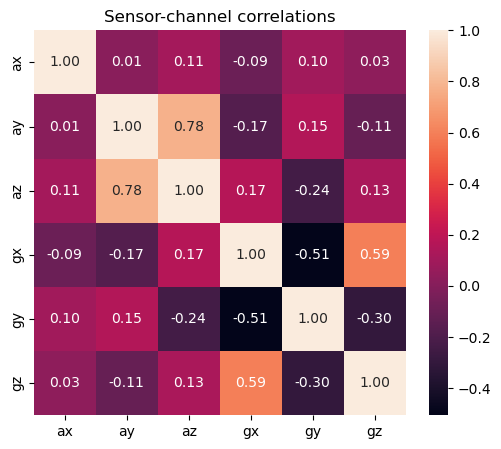

In [8]:
# Correlation heatmap for sensor channels
plt.figure(figsize=(6,5))
sns.heatmap(df_all[SENSOR_COLUMNS].corr(), annot=True, fmt='.2f')
plt.title('Sensor-channel correlations')
plt.show()

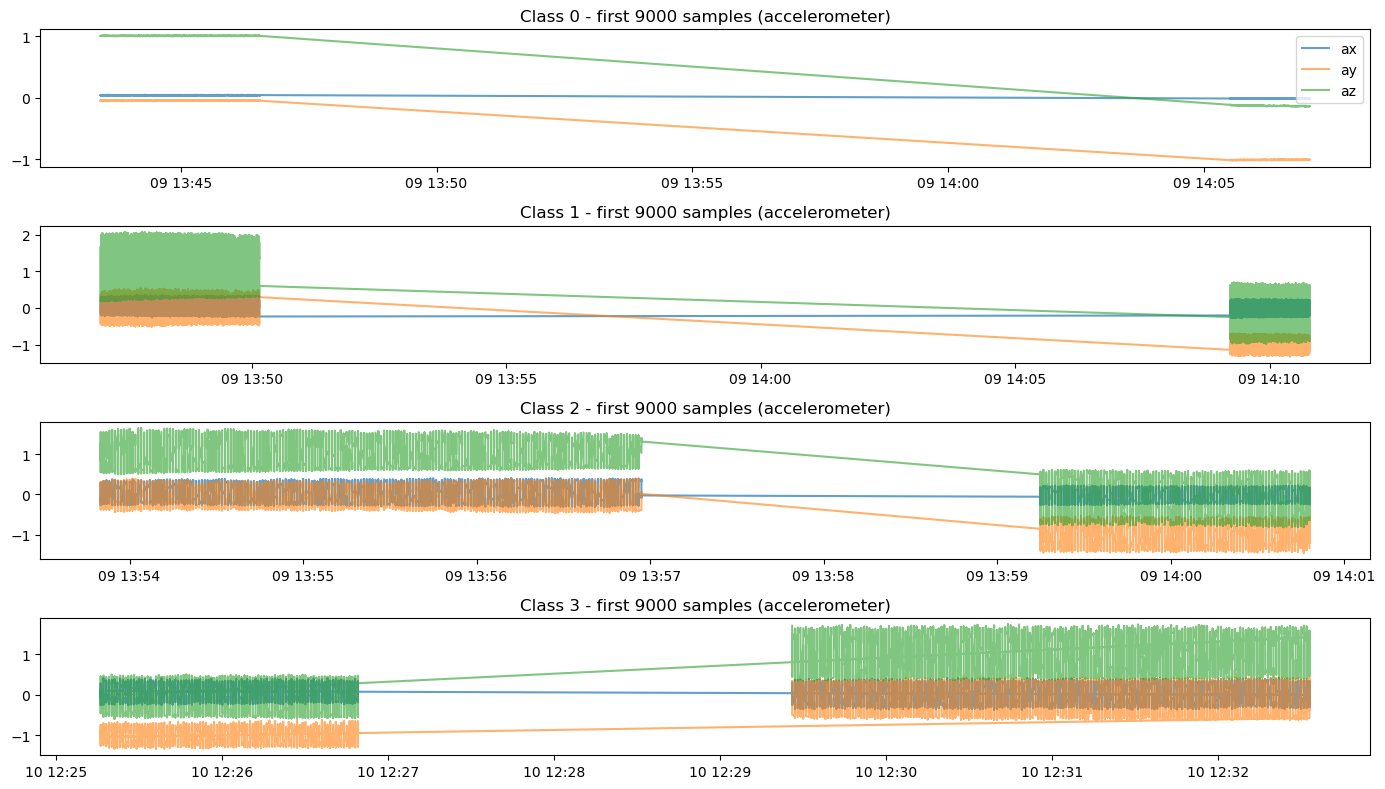

In [9]:
# Plot a short time-series snippet per class for visual inspection
plt.figure(figsize=(14,8))
unique_labels = sorted(df_all[LABEL_COLUMN].unique())[:4]
for i, lab in enumerate(unique_labels, 1):
    plt.subplot(len(unique_labels), 1, i)
    sub = df_all[df_all[LABEL_COLUMN] == lab].head(9000)  # first 1000 samples of that class
    if TIME_COLUMN in sub.columns:
        x = sub[TIME_COLUMN]
    else:
        x = np.arange(len(sub))
    plt.plot(x, sub['ax'].values, label='ax', alpha=0.7)
    plt.plot(x, sub['ay'].values, label='ay', alpha=0.6)
    plt.plot(x, sub['az'].values, label='az', alpha=0.6)
    plt.title(f'Class {lab} - first 9000 samples (accelerometer)')
    if i == 1:
        plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Preprocessing

In [11]:
# Windowing raw signals into model-ready arrays
# Creating sliding windows without label-mixing: taking contiguous windows and assigning them
# the most-common label within the window (majority vote). This avoids feature engineering.

# Create numpy arrays from sensors and labels
sensors_arr = df_all[SENSOR_COLUMNS].values.astype('float32')
labels_arr = df_all[LABEL_COLUMN].values

print('Sensors shape (samples, channels):', sensors_arr.shape)

# Sliding window generator
def make_windows(data, labels, window_size=WINDOW_SIZE, step=STEP):
    X = []
    y = []
    n_samples = data.shape[0]
    for start in range(0, n_samples - window_size + 1, step):
        end = start + window_size
        win = data[start:end]
        lab_win = labels[start:end]
        # majority label in the window
        vals, counts = np.unique(lab_win, return_counts=True)
        label = vals[np.argmax(counts)]
        X.append(win)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = make_windows(sensors_arr, labels_arr, WINDOW_SIZE, STEP)
print('Windows created: X shape =', X.shape, 'y shape =', y.shape)

# Encode labels to 0..n-1
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Label classes:', le.classes_)

Sensors shape (samples, channels): (72000, 6)
Windows created: X shape = (280, 512, 6) y shape = (280,)
Label classes: [0 1 2 3]


In [12]:
# Train/test split (stratified by window label)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_enc, test_size=TEST_SIZE, random_state=SEED, stratify=y_enc
)
# Further split train->train+val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=VAL_SIZE, random_state=SEED, stratify=y_trainval
)

print('Train/Val/Test shapes:', X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test shapes: (156, 512, 6) (40, 512, 6) (84, 512, 6)


In [13]:
# Scale channels using StandardScaler fit on train windows (fit per channel across all windows/timepoints)
# Reshaping to (n_windows * window_size, n_channels) to fit scaler and then reshape back.

n_channels = X.shape[2]
scaler = StandardScaler()
reshaped = X_train.reshape(-1, n_channels)
scaler.fit(reshaped)

# transform datasets
X_train_scaled = scaler.transform(X_train.reshape(-1, n_channels)).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_channels)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_channels)).reshape(X_test.shape)

# Convert labels to categorical
num_classes = len(le.classes_)
y_train_cat = utils.to_categorical(y_train, num_classes)
y_val_cat = utils.to_categorical(y_val, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# For Keras: ensure dtype float32
X_train_scaled = X_train_scaled.astype('float32')
X_val_scaled = X_val_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')

## Model Architecture

In [15]:
# 1D-CNN backbone -> DNN (Dense layers)

model = models.Sequential([
    layers.Input(shape=(WINDOW_SIZE, n_channels)),
    layers.GaussianNoise(0.02),                     # small noise in-model

    layers.Conv1D(32, kernel_size=7, padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.SpatialDropout1D(0.2),
    layers.MaxPooling1D(2),

    layers.Conv1D(64, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.SpatialDropout1D(0.25),
    layers.MaxPooling1D(2),

    layers.Conv1D(128, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalAveragePooling1D(),

    layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 512, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 512, 32)        │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 512, 32)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 256, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 256, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 256, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,356 (282.64 KB)

 Trainable params: 71,396 (278.89 KB)

 Non-trainable params: 960 (3.75 KB)

## Model Training

In [17]:
# Training

# Callbacks
es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)


history = model.fit(
X_train_scaled, y_train_cat,
validation_data=(X_val_scaled, y_val_cat),
epochs=EPOCHS,
batch_size=BATCH_SIZE,
callbacks=[es, rl]
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.2316 - loss: 2.1164 - val_accuracy: 0.2500 - val_loss: 1.4572 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4557 - loss: 1.4057 - val_accuracy: 0.2500 - val_loss: 1.4547 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4981 - loss: 1.2276 - val_accuracy: 0.2500 - val_loss: 1.4419 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5143 - loss: 1.1722 - val_accuracy: 0.1500 - val_loss: 1.4167 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5551 - loss: 1.1189 - val_accuracy: 0.2500 - val_loss: 1.3795 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5980 - loss: 1.0484 - val_accuracy: 0.2500 - val_loss: 1.3303 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6987 - loss: 0.9122 - val_accuracy: 

## Evaluation

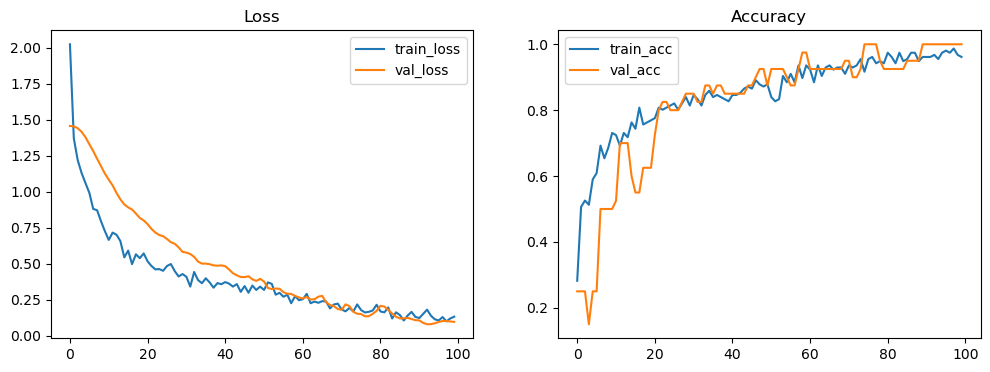

In [19]:
# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [20]:
# Using trained model from this session (no disk loading since saving was disabled)
best = model

# Evaluate on test set
test_loss, test_acc = best.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

# Predictions -> classification report
y_pred_probs = best.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

print('\nClassification report:')
print(classification_report(y_test, y_pred, target_names=[str(c) for c in le.classes_]))

Test loss: 0.0777, Test accuracy: 1.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        21

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



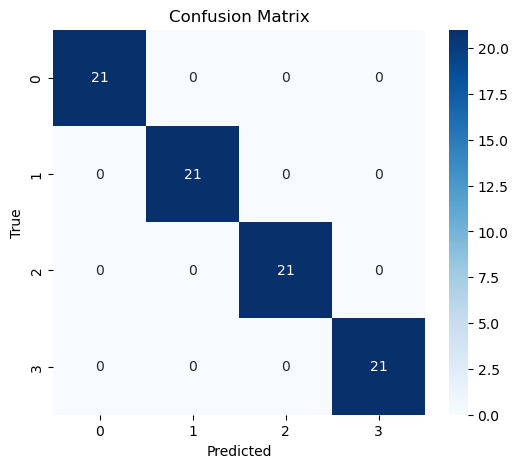

In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()